## Read Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from statsmodels.tsa.ar_model import AutoReg

import os
import sys


In [2]:
data_path = 'C:/Users/fe_ma/Data/'


In [3]:
# data_path = 'C:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\data'
def read_data(data_path):
  files_pm = {}

  files_pm['hashprice'] = {'file_name': 'bitcoin-hashprice-index-20251110.csv'}
  files_pm['hashprice']['col_date_name'] = 'timestamp'
  files_pm['hashprice']['col_price'] = 'usd_hashprice'

  files_pm['btc'] = {'file_name': 'BTC-USD.csv'}
  files_pm['btc']['col_date_name'] = 'Date'
  files_pm['btc']['col_price'] = 'Adj Close'

  files_pm['electricity'] = {'file_name': 'Electricity data ERCOT.csv'}
  files_pm['electricity']['col_date_name'] = 'Date'
  files_pm['electricity']['col_price'] = 'price'

  df_data = pd.DataFrame([])
  for key, pm in files_pm.items():
    file_name = pm['file_name']
    col_date_name = pm['col_date_name']
    file_path = os.path.join(data_path, file_name)
    df_data_aux = pd.read_csv(file_path)

    df_data_aux[col_date_name] = pd.to_datetime(df_data_aux[col_date_name])
    df_data_aux['date_aux'] = df_data_aux[col_date_name].dt.strftime('%Y-%m-%d')
    df_data_aux['date_aux'] = pd.to_datetime(df_data_aux['date_aux'], format='%Y-%m-%d')
    df_data_aux = df_data_aux.pivot_table(index='date_aux', values=pm['col_price'], aggfunc='mean')

    df_data_aux = df_data_aux[[pm['col_price']]]
    df_data_aux.rename(columns={pm['col_price']: key}, inplace=True)
    df_data_aux.index.name = 'date'
    df_data_aux.sort_index(inplace=True)

    df_data = pd.concat([df_data, df_data_aux], axis=1)
  df_data.dropna(inplace=True)
  return df_data


In [4]:
def fit_electricity(df_data_ret):
  column = 'electricity'
  df_elec_log = df_data_ret[[column]].copy()
  df_elec_log['year'] = df_elec_log.index.year

  T_year = 364
  T_month = 364 / 12

  df_elec_log.index
  dates = df_elec_log.index
  date_min = dates.min()
  # parameters = {}
  df_elec_log['days'] = (dates - date_min).days
  df_elec_log['days'] = df_elec_log['days'].astype(int)
  df_elec_log['sin_year'] = np.sin(2 * np.pi * df_elec_log['days'] / T_year)
  df_elec_log['cos_year'] = np.cos(2 * np.pi * df_elec_log['days'] / T_year)
  df_elec_log['sin_month'] = np.sin(2 * np.pi * df_elec_log['days'] / T_month)
  df_elec_log['cos_month'] = np.cos(2 * np.pi * df_elec_log['days'] / T_month)
  df_elec_log['constant'] = 1
  # parameters['date_min'] = date_min
  # parameters['fourier'] = {}

  # X = np.matrix(df_elec_log[['constant', 'sin_year', 'cos_year']])
  X = np.matrix(df_elec_log[['constant', 'sin_year', 'cos_year', 'sin_month', 'cos_month']])
  Y = np.matrix(df_elec_log[[column]])

  alpha = np.linalg.inv(X.T @ X) @ (X.T @ Y)
  # parameters['fourier'] = {'constant': alpha[0][0]}
  # parameters['fourier']['sin_year'] = alpha[1][0]
  # parameters['fourier']['cos_year'] = alpha[2][0]
  # parameters['fourier']['sin_month'] = alpha[3][0]
  # parameters['fourier']['cos_month'] = alpha[4][0]

  df_elec_log[column+'_model'] = X @ alpha
  df_elec_log['residual'] = df_elec_log[column] - df_elec_log[column+'_model']

  # Model X_t using an AR(1) process (a simple mean-reverting model)
  # We use trend='n' because the residuals should be zero-mean by definition
  ar_model = AutoReg(df_elec_log['residual'].values, lags=1, trend='n')
  ar_model_fit = ar_model.fit()

  # Get the parameters for our simulation
  # phi is the mean-reversion parameter (autoregressive term)
  phi = ar_model_fit.params[0]

  # sigma_epsilon is the standard deviation of the random shocks
  sigma_epsilon = np.std(ar_model_fit.resid)
  # parameters['ar'] = {'phi': phi, 'sigma': sigma_epsilon}
  # Generate the shocks
  shocks = np.random.normal(0, sigma_epsilon, len(df_elec_log))

  # Generate the AR(1) process
  df_elec_log['ar'] = phi * df_elec_log['residual'].shift()
  df_elec_log['model'] = df_elec_log['ar'] + df_elec_log[column+'_model']
  df_elec_log['residual_ar'] = df_elec_log[column] - df_elec_log['model']

  df_electricity = df_elec_log[[column, 'model', 'residual_ar']]

  electricity_params = {
    'alpha': alpha,  # Seasonal coefficients
    'phi': phi,  # AR(1) coefficient
    'sigma_epsilon': sigma_epsilon,  # Innovation std dev
    'T_year': T_year,
    'T_month': T_month,
    'date_min': date_min,
    'last_elec_log_price': df_elec_log[column].iloc[-1],
    'last_residual': df_elec_log['residual_ar'].iloc[-1]  # Last residual for AR(1) initialization
  }
  return df_electricity, electricity_params

In [5]:
def calculate_multivariate_params(df_combined):
    # Calculate multivariate parameters
    mu_daily = df_combined.mean().values
    cov_daily = df_combined.cov().values
    corr_matrix = df_combined.corr().values
    sigma_daily = np.sqrt(np.diag(cov_daily))

    # Annualize
    mu_annual = mu_daily * 365
    cov_annual = cov_daily * 365
    sigma_annual = sigma_daily * np.sqrt(365)

    multivariate_params = {
        'mu_daily': mu_daily,
        'mu_annual': mu_annual,
        'cov_daily': cov_daily,
        'cov_annual': cov_annual,
        'corr_matrix': corr_matrix,
        'sigma_daily': sigma_daily,
        'sigma_annual': sigma_annual,
        'series_names': df_combined.columns.tolist()
    }
    return multivariate_params

In [6]:
df_data = read_data(data_path)

report_date = dt.date(2024, 1, 1)
n_train = 1000
n_test = 100
df_data_train = df_data[report_date - dt.timedelta(days=n_train): report_date]
df_data_test = df_data[report_date: report_date+dt.timedelta(days=n_test)]

df_data_test.head()

,hashprice,btc,electricity
date,,,
2024-01-01,98.96,44167.332031,22.065000
2024-01-02,93.54,44957.968750,27.813646
2024-01-03,88.74,42848.175781,27.018073
2024-01-04,86.34,44179.921875,19.375469
2024-01-05,85.82,44162.691406,22.410521


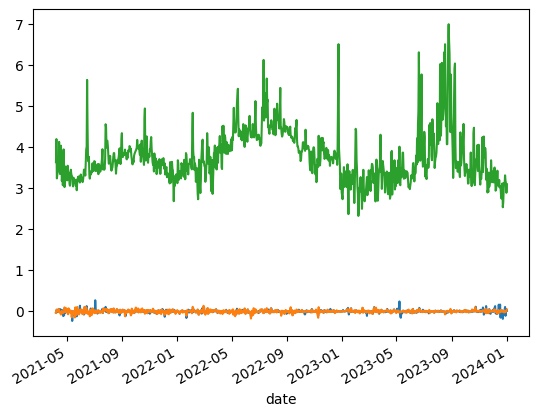

In [7]:
df_data_ret = np.log(df_data_train)
df_data_ret[['hashprice', 'btc']] = df_data_ret[['hashprice', 'btc']].diff()
df_data_ret.dropna(inplace=True)

# df_data_ret.plot()
fit_models = {'hashprice': 'brownian', 'btc': 'brownian', 'electricity': 'fit_electricity'}

for key, model in fit_models.items():
  df_data_ret[key].plot()

## Fit Models: Brownian Motion + Electricity (Seasonal + AR(1) with Correlation)


In [8]:
# Step 1: Fit electricity model with seasonal + AR(1) structure
print("Fitting Electricity Model (Seasonal + AR(1))...")
print("=" * 60)

df_electricity_fit, electricity_params = fit_electricity(df_data_ret)
electricity_residuals = df_electricity_fit['residual_ar'].dropna()

# Step 2: Align electricity residuals with hashprice/btc returns
brownian_series = [key for key, model in fit_models.items() if model == 'brownian']
df_returns_brownian = df_data_ret[brownian_series].copy()

df_combined = df_returns_brownian.copy()
df_combined['electricity'] = electricity_residuals
df_combined = df_combined.dropna()

multivariate_params = calculate_multivariate_params(df_combined)

Fitting Electricity Model (Seasonal + AR(1))...


In [9]:
def simulate_multivariate_with_electricity(multivariate_params, electricity_params, n_days, 
                                           n_simulations=1000, start_date=None, random_seed=None):
    """
    Simulate multivariate paths including:
    - Hashprice and BTC returns (Brownian motion with Itô correction)
    - Electricity residuals (AR(1) with correlation to hashprice/BTC)
    - Electricity prices (seasonal component + AR(1) residuals)
    
    Parameters:
    -----------
    multivariate_params : dict
        Parameters for multivariate model including hashprice, btc, and electricity_residual
    electricity_params : dict
        Parameters for electricity model (seasonal, AR(1))
    n_days : int
        Number of days to simulate
    n_simulations : int
        Number of simulation paths
    start_date : pd.Timestamp, optional
        Start date for simulation (for seasonal component)
    random_seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Dictionary with simulated paths
        - 'hashprice': returns paths
        - 'btc': returns paths
        - 'electricity_residual': residual paths
        - 'electricity': price paths (log prices)
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    # Get indices for each series
    series_names = multivariate_params['series_names']
    hashprice_idx = series_names.index('hashprice')
    btc_idx = series_names.index('btc')
    electricity_idx = series_names.index('electricity')

    # Extract parameters
    mu_daily = multivariate_params['mu_daily']
    cov_daily = multivariate_params['cov_daily']

    # Electricity parameters
    phi = electricity_params['phi']
    sigma_epsilon = electricity_params['sigma_epsilon']
    alpha = electricity_params['alpha']
    T_year = electricity_params['T_year']
    T_month = electricity_params['T_month']
    date_min = electricity_params['date_min']
    last_elec_log_price = electricity_params['last_elec_log_price']
    last_elec_residual = electricity_params['last_residual']

    # Set start date for seasonal component (use last date from training data)
    if start_date is None:
        start_date = df_data_ret.index[-1] + pd.Timedelta(days=1)

    # Initialize arrays
    n_series = len(series_names)
    paths = np.zeros((n_simulations, n_series, n_days + 1))

    # Initialize electricity residuals with last observed residual
    paths[:, electricity_idx, 0] = last_elec_residual

    # Cholesky decomposition for correlated shocks
    try:
        L = np.linalg.cholesky(cov_daily)
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix not positive definite. Adding regularization.")
        cov_daily = cov_daily + np.eye(len(cov_daily)) * 1e-8
        L = np.linalg.cholesky(cov_daily)

    # Extract variances for Itô correction (only for Brownian motion series)
    sigma_squared_daily = np.diag(cov_daily)

    # Generate independent standard normal random variables
    Z = np.random.normal(0, 1, size=(n_simulations, n_days, n_series))

    # Transform to correlated random variables
    correlated_shocks = np.dot(Z, L.T)

    # Simulate paths
    for t in range(n_days):
        # For hashprice and btc: independent period returns with Itô correction
        # For electricity_residual: AR(1) with correlated innovation
        
        # Generate period returns for hashprice and btc
        period_returns = (mu_daily - 0.5 * sigma_squared_daily) + correlated_shocks[:, t, :]
        paths[:, hashprice_idx, t+1] = period_returns[:, hashprice_idx]
        paths[:, btc_idx, t+1] = period_returns[:, btc_idx]
        
        # For electricity residual: AR(1) process
        # ε_t = φ * ε_{t-1} + σ_ε * innovation_t
        # The innovation is correlated with hashprice/btc shocks via Cholesky
        # The correlated_shock already has the right correlation structure
        # But we need to scale it by sigma_epsilon for the AR(1) innovation
        # Note: The covariance matrix includes electricity_residual, so the correlated shock
        # already accounts for correlation. We just need to use it as the innovation.
        elec_innovation = correlated_shocks[:, t, electricity_idx]
        # Scale by sigma_epsilon to match the AR(1) innovation variance
        # The correlated shock has std dev from covariance, we need to normalize
        elec_std_from_cov = np.sqrt(cov_daily[electricity_idx, electricity_idx])
        normalized_innovation = elec_innovation / elec_std_from_cov * sigma_epsilon
        paths[:, electricity_idx, t+1] = (
            phi * paths[:, electricity_idx, t] + 
            normalized_innovation
        )

    # Reconstruct electricity prices from residuals
    # Calculate dates for seasonal component
    dates = pd.date_range(start=start_date, periods=n_days+1, freq='D')

    # Initialize electricity price paths (log prices)
    electricity_prices = np.zeros((n_simulations, n_days + 1))

    # Get last observed electricity log price
    # last_elec_price = df_data_train['electricity'].iloc[-1]
    electricity_prices[:, 0] = last_elec_log_price

    # last_elec_log_price = np.log(df_data_train['electricity'].iloc[-1])
    # electricity_prices[:, 0] = last_elec_log_price

    # Calculate seasonal component and reconstruct prices for each time step
    for t in range(n_days + 1):
        # Calculate days from date_min for seasonal component
        days = (dates[t] - date_min).days
        
        sin_year = np.sin(2 * np.pi * days / T_year)
        cos_year = np.cos(2 * np.pi * days / T_year)
        sin_month = np.sin(2 * np.pi * days / T_month)
        cos_month = np.cos(2 * np.pi * days / T_month)
        
        seasonal = (
            alpha[0, 0] +  # constant
            alpha[1, 0] * sin_year +
            alpha[2, 0] * cos_year +
            alpha[3, 0] * sin_month +
            alpha[4, 0] * cos_month
        )
        
        # Electricity log price = seasonal + residual
        if t == 0:
            # Initial price: use last observed price (should match seasonal + last residual)
            electricity_prices[:, t] = last_elec_log_price
        else:
            # Update: seasonal component + AR(1) residual
            electricity_prices[:, t] = seasonal + paths[:, electricity_idx, t]
    
    return {
            'hashprice': paths[:, hashprice_idx, :],
            'btc': paths[:, btc_idx, :],
            # 'electricity_residual': paths[:, elec_residual_idx, :],
            'electricity': electricity_prices
        }

In [10]:

# Generate multivariate simulations with electricity AR(1) + correlation
n_days_forecast = 366
n_simulations = 10000

print("Generating Multivariate Monte Carlo simulations...")
print(f"  - Hashprice & BTC: Brownian motion with Itô correction")
print(f"  - Electricity: Seasonal + AR(1) residuals with correlation")
print(f"Simulating {n_simulations} paths over {n_days_forecast} days")
print("=" * 60)

# Get start date (day after last training date)
start_date = df_data_ret.index[-1] + pd.Timedelta(days=1)

# Simulate all series together with covariance and electricity AR(1)
simulations = simulate_multivariate_with_electricity(
    multivariate_params=multivariate_params,
    electricity_params=electricity_params,
    n_days=n_days_forecast,
    n_simulations=n_simulations,
    start_date=start_date,
    random_seed=42
)

print(f"\nGenerated simulations:")
for key in simulations.keys():
    print(f"  {key}: {n_simulations} paths over {n_days_forecast} days")

# Verify correlation in simulations
check_day = min(10, n_days_forecast)
hashprice_returns = simulations['hashprice'][:, check_day]
btc_returns = simulations['btc'][:, check_day]
elec_residuals = simulations['electricity'][:, check_day]

sim_corr_hb = np.corrcoef(hashprice_returns, btc_returns)[0,1]
sim_corr_he = np.corrcoef(hashprice_returns, elec_residuals)[0,1]
sim_corr_be = np.corrcoef(btc_returns, elec_residuals)[0,1]

print(f"\nSimulated Correlations (day {check_day}):")
print(f"  Hashprice - BTC: {sim_corr_hb:.4f} (target: {multivariate_params['corr_matrix'][0,1]:.4f})")
print(f"  Hashprice - Electricity Residual: {sim_corr_he:.4f} (target: {multivariate_params['corr_matrix'][0,2]:.4f})")
print(f"  BTC - Electricity Residual: {sim_corr_be:.4f} (target: {multivariate_params['corr_matrix'][1,2]:.4f})")

simulations

Generating Multivariate Monte Carlo simulations...
  - Hashprice & BTC: Brownian motion with Itô correction
  - Electricity: Seasonal + AR(1) residuals with correlation
Simulating 10000 paths over 366 days

Generated simulations:
  hashprice: 10000 paths over 366 days
  btc: 10000 paths over 366 days
  electricity: 10000 paths over 366 days

Simulated Correlations (day 10):
  Hashprice - BTC: 0.3992 (target: 0.4202)
  Hashprice - Electricity Residual: 0.0189 (target: 0.0100)
  BTC - Electricity Residual: 0.0183 (target: 0.0246)


{'hashprice': array([[ 0.        ,  0.01647413,  0.05451686, ..., -0.00921587,
          0.02503353, -0.00492966],
        [ 0.        ,  0.03202806, -0.10929403, ..., -0.01182179,
         -0.06117584, -0.05246687],
        [ 0.        ,  0.01384877,  0.01614638, ...,  0.05378997,
         -0.02520611, -0.09415402],
        ...,
        [ 0.        , -0.02299583,  0.00842273, ..., -0.00735639,
         -0.07498079, -0.08327014],
        [ 0.        ,  0.01347696, -0.02692834, ..., -0.04541913,
         -0.03077707, -0.06602434],
        [ 0.        ,  0.02229141, -0.01378202, ..., -0.00074868,
          0.06736499,  0.06644543]], shape=(10000, 367)),
 'btc': array([[ 0.        ,  0.00192668,  0.01303643, ..., -0.00551972,
          0.01062924,  0.00044868],
        [ 0.        ,  0.02181506,  0.02112913, ..., -0.01694807,
         -0.00889605, -0.01369003],
        [ 0.        ,  0.00557659,  0.05870365, ...,  0.00995973,
         -0.01770907,  0.00290297],
        ...,
        [ 0.  

In [11]:
# # Step 1: Fit electricity model with seasonal + AR(1) structure
# print("Fitting Electricity Model (Seasonal + AR(1))...")
# print("=" * 60)

# df_electricity_fit, electricity_params = fit_electricity(df_data_ret)
# electricity_residuals = df_electricity_fit['residual_ar'].dropna()

# # Step 2: Align electricity residuals with hashprice/btc returns
# brownian_series = [key for key, model in fit_models.items() if model == 'brownian']
# df_returns_brownian = df_data_ret[brownian_series].copy()

# # Align indices
# common_index = df_returns_brownian.index.intersection(electricity_residuals.index)
# df_returns_brownian = df_returns_brownian.loc[common_index]
# electricity_residuals_aligned = electricity_residuals.loc[common_index]

# # Step 3: Fit multivariate model including electricity residuals
# print(f"\nFitting Multivariate Model (Hashprice, BTC, Electricity Residuals)...")
# print("=" * 60)

# # Create combined dataframe: hashprice returns, btc returns, electricity residuals
# df_combined = df_returns_brownian.copy()
# df_combined['electricity_residual'] = electricity_residuals_aligned.values

# # Calculate multivariate parameters
# mu_daily = df_combined.mean().values
# cov_daily = df_combined.cov().values
# corr_matrix = df_combined.corr().values
# sigma_daily = np.sqrt(np.diag(cov_daily))

# # Annualize
# mu_annual = mu_daily * 365
# cov_annual = cov_daily * 365
# sigma_annual = sigma_daily * np.sqrt(365)

# multivariate_params = {
#     'mu_daily': mu_daily,
#     'mu_annual': mu_annual,
#     'cov_daily': cov_daily,
#     'cov_annual': cov_annual,
#     'corr_matrix': corr_matrix,
#     'sigma_daily': sigma_daily,
#     'sigma_annual': sigma_annual,
#     'series_names': df_combined.columns.tolist()
# }

# # Store electricity-specific parameters
# # electricity_params = {}
# # electricity_params = {
# #     'alpha': alpha,  # Seasonal coefficients
# #     'phi': phi_electricity,  # AR(1) coefficient
# #     'sigma_epsilon': sigma_epsilon_electricity,  # Innovation std dev
# #     'T_year': T_year,
# #     'T_month': T_month,
# #     'date_min': date_min,
# #     'last_residual': electricity_residuals_aligned.iloc[-1]  # Last residual for AR(1) initialization
# # }

# print("\nMultivariate Model Parameters:")
# print("=" * 60)
# for i, series_name in enumerate(multivariate_params['series_names']):
#     print(f"\n{series_name.upper()}:")
#     print(f"  Daily drift (μ): {multivariate_params['mu_daily'][i]:.6f}")
#     print(f"  Daily volatility (σ): {multivariate_params['sigma_daily'][i]:.6f}")

# print(f"\nDaily Covariance Matrix:")
# print(multivariate_params['cov_daily'])
# print(f"\nCorrelation Matrix:")
# print(multivariate_params['corr_matrix'])

# # Show correlations with electricity residuals
# if 'electricity_residual' in multivariate_params['series_names']:
#     elec_idx = multivariate_params['series_names'].index('electricity_residual')
#     print(f"\nCorrelations with Electricity Residuals:")
#     for i, name in enumerate(multivariate_params['series_names']):
#         if name != 'electricity_residual':
#             print(f"  {name} - electricity_residual: {corr_matrix[i, elec_idx]:.4f}")

# multivariate_params, electricity_params


## Multivariate Monte Carlo Simulation Functions (with Electricity AR(1) + Correlation)


In [12]:
def simulate_multivariate_with_electricity(multivariate_params, electricity_params, n_days, 
                                           n_simulations=1000, start_date=None, random_seed=None):
    """
    Simulate multivariate paths including:
    - Hashprice and BTC returns (Brownian motion with Itô correction)
    - Electricity residuals (AR(1) with correlation to hashprice/BTC)
    - Electricity prices (seasonal component + AR(1) residuals)
    
    Parameters:
    -----------
    multivariate_params : dict
        Parameters for multivariate model including hashprice, btc, and electricity_residual
    electricity_params : dict
        Parameters for electricity model (seasonal, AR(1))
    n_days : int
        Number of days to simulate
    n_simulations : int
        Number of simulation paths
    start_date : pd.Timestamp, optional
        Start date for simulation (for seasonal component)
    random_seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Dictionary with simulated paths
        - 'hashprice': returns paths
        - 'btc': returns paths
        - 'electricity_residual': residual paths
        - 'electricity': price paths (log prices)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Get indices for each series
    series_names = multivariate_params['series_names']
    hashprice_idx = series_names.index('hashprice')
    btc_idx = series_names.index('btc')
    elec_residual_idx = series_names.index('electricity_residual')
    
    # Extract parameters
    mu_daily = multivariate_params['mu_daily']
    cov_daily = multivariate_params['cov_daily']
    
    # Electricity parameters
    phi = electricity_params['phi']
    sigma_epsilon = electricity_params['sigma_epsilon']
    alpha = electricity_params['alpha']
    T_year = electricity_params['T_year']
    T_month = electricity_params['T_month']
    date_min = electricity_params['date_min']
    last_residual = electricity_params['last_residual']
    
    # Set start date for seasonal component (use last date from training data)
    if start_date is None:
        start_date = df_data_ret.index[-1] + pd.Timedelta(days=1)
    
    # Initialize arrays
    n_series = len(series_names)
    paths = np.zeros((n_simulations, n_series, n_days + 1))
    
    # Initialize electricity residuals with last observed residual
    paths[:, elec_residual_idx, 0] = last_residual
    
    # Cholesky decomposition for correlated shocks
    try:
        L = np.linalg.cholesky(cov_daily)
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix not positive definite. Adding regularization.")
        cov_daily = cov_daily + np.eye(len(cov_daily)) * 1e-8
        L = np.linalg.cholesky(cov_daily)
    
    # Extract variances for Itô correction (only for Brownian motion series)
    sigma_squared_daily = np.diag(cov_daily)
    
    # Generate independent standard normal random variables
    Z = np.random.normal(0, 1, size=(n_simulations, n_days, n_series))
    
    # Transform to correlated random variables
    correlated_shocks = np.dot(Z, L.T)
    
    # Simulate paths
    for t in range(n_days):
        # For hashprice and btc: independent period returns with Itô correction
        # For electricity_residual: AR(1) with correlated innovation
        
        # Generate period returns for hashprice and btc
        period_returns = (mu_daily - 0.5 * sigma_squared_daily) + correlated_shocks[:, t, :]
        paths[:, hashprice_idx, t+1] = period_returns[:, hashprice_idx]
        paths[:, btc_idx, t+1] = period_returns[:, btc_idx]
        
        # For electricity residual: AR(1) process
        # ε_t = φ * ε_{t-1} + σ_ε * innovation_t
        # The innovation is correlated with hashprice/btc shocks via Cholesky
        # The correlated_shock already has the right correlation structure
        # But we need to scale it by sigma_epsilon for the AR(1) innovation
        # Note: The covariance matrix includes electricity_residual, so the correlated shock
        # already accounts for correlation. We just need to use it as the innovation.
        elec_innovation = correlated_shocks[:, t, elec_residual_idx]
        # Scale by sigma_epsilon to match the AR(1) innovation variance
        # The correlated shock has std dev from covariance, we need to normalize
        elec_std_from_cov = np.sqrt(cov_daily[elec_residual_idx, elec_residual_idx])
        normalized_innovation = elec_innovation / elec_std_from_cov * sigma_epsilon
        paths[:, elec_residual_idx, t+1] = (
            phi * paths[:, elec_residual_idx, t] + 
            normalized_innovation
        )
    
    # Reconstruct electricity prices from residuals
    # Calculate dates for seasonal component
    dates = pd.date_range(start=start_date, periods=n_days+1, freq='D')
    
    # Initialize electricity price paths (log prices)
    electricity_prices = np.zeros((n_simulations, n_days + 1))
    
    # Get last observed electricity log price
    last_elec_log_price = np.log(df_data_train['electricity'].iloc[-1])
    electricity_prices[:, 0] = last_elec_log_price
    
    # Calculate seasonal component and reconstruct prices for each time step
    for t in range(n_days + 1):
        # Calculate days from date_min for seasonal component
        days = (dates[t] - date_min).days
        
        sin_year = np.sin(2 * np.pi * days / T_year)
        cos_year = np.cos(2 * np.pi * days / T_year)
        sin_month = np.sin(2 * np.pi * days / T_month)
        cos_month = np.cos(2 * np.pi * days / T_month)
        
        seasonal = (
            alpha[0, 0] +  # constant
            alpha[1, 0] * sin_year +
            alpha[2, 0] * cos_year +
            alpha[3, 0] * sin_month +
            alpha[4, 0] * cos_month
        )
        
        # Electricity log price = seasonal + residual
        if t == 0:
            # Initial price: use last observed price (should match seasonal + last residual)
            electricity_prices[:, t] = last_elec_log_price
        else:
            # Update: seasonal component + AR(1) residual
            electricity_prices[:, t] = seasonal + paths[:, elec_residual_idx, t]
    
    return {
        'hashprice': paths[:, hashprice_idx, :],
        'btc': paths[:, btc_idx, :],
        'electricity_residual': paths[:, elec_residual_idx, :],
        'electricity': electricity_prices
    }


## Visualize Monte Carlo Simulations


In [13]:
# simulations.keys()

Plotting hashprice with 10000 simulations
Plotting btc with 10000 simulations
Plotting electricity with 10000 simulations


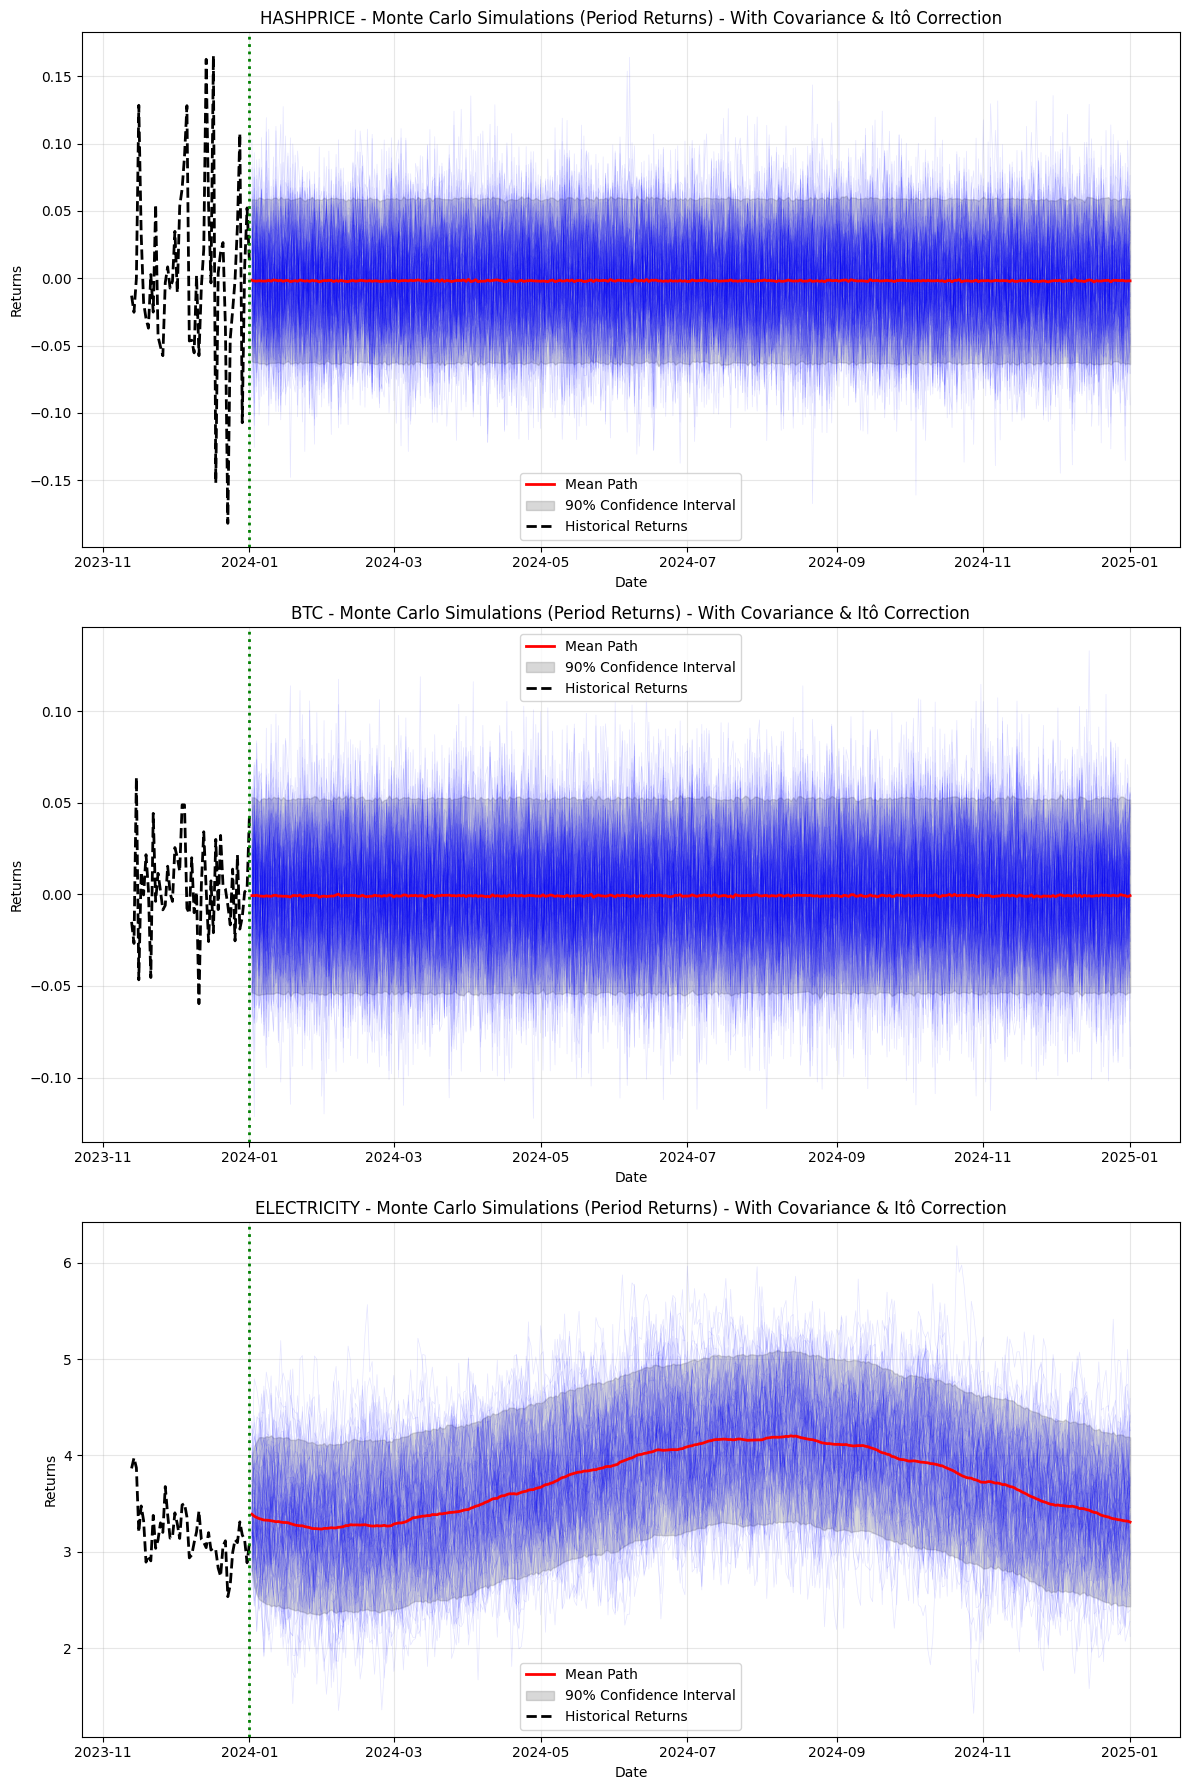

In [14]:
import matplotlib.pyplot as plt

# Create future dates for plotting
last_date = df_data_ret.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days_forecast, freq='D')

# Plot simulations for each series
fig, axes = plt.subplots(len(simulations), 1, figsize=(12, 6 * len(simulations)))
if len(simulations) == 1:
    axes = [axes]

for idx, (key, paths) in enumerate(simulations.items()):
    # key = key.replace('_residual', '')
    print(f"Plotting {key} with {n_simulations} simulations")
    ax = axes[idx]
    
    # Plot all simulation paths (with transparency)
    for i in range(min(100, n_simulations)):  # Plot first 100 paths for clarity
        ax.plot(future_dates, paths[i, 1:], alpha=0.1, color='blue', linewidth=0.5)
    
    # Plot mean path
    mean_path = np.mean(paths, axis=0)
    ax.plot(future_dates, mean_path[1:], color='red', linewidth=2, label='Mean Path')
    
    # Plot confidence intervals (5th and 95th percentiles)
    percentile_5 = np.percentile(paths, 5, axis=0)
    percentile_95 = np.percentile(paths, 95, axis=0)
    ax.fill_between(future_dates, percentile_5[1:], percentile_95[1:], 
                     alpha=0.3, color='gray', label='90% Confidence Interval')
    
    # Plot historical data (last 50 days for context)
    historical_dates = df_data_ret.index[-50:]
    historical_values = df_data_ret[key].values[-50:]
    ax.plot(historical_dates, historical_values, color='black', linewidth=2, 
            label='Historical Returns', linestyle='--')
    
    ax.set_title(f'{key.upper()} - Monte Carlo Simulations (Period Returns) - With Covariance & Itô Correction')
    ax.set_xlabel('Date')
    ax.set_ylabel('Returns')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add vertical line to separate historical and forecast
    ax.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Forecast Start')

plt.tight_layout()
plt.show()

## Convert Returns Back to Price Levels (with Covariance)


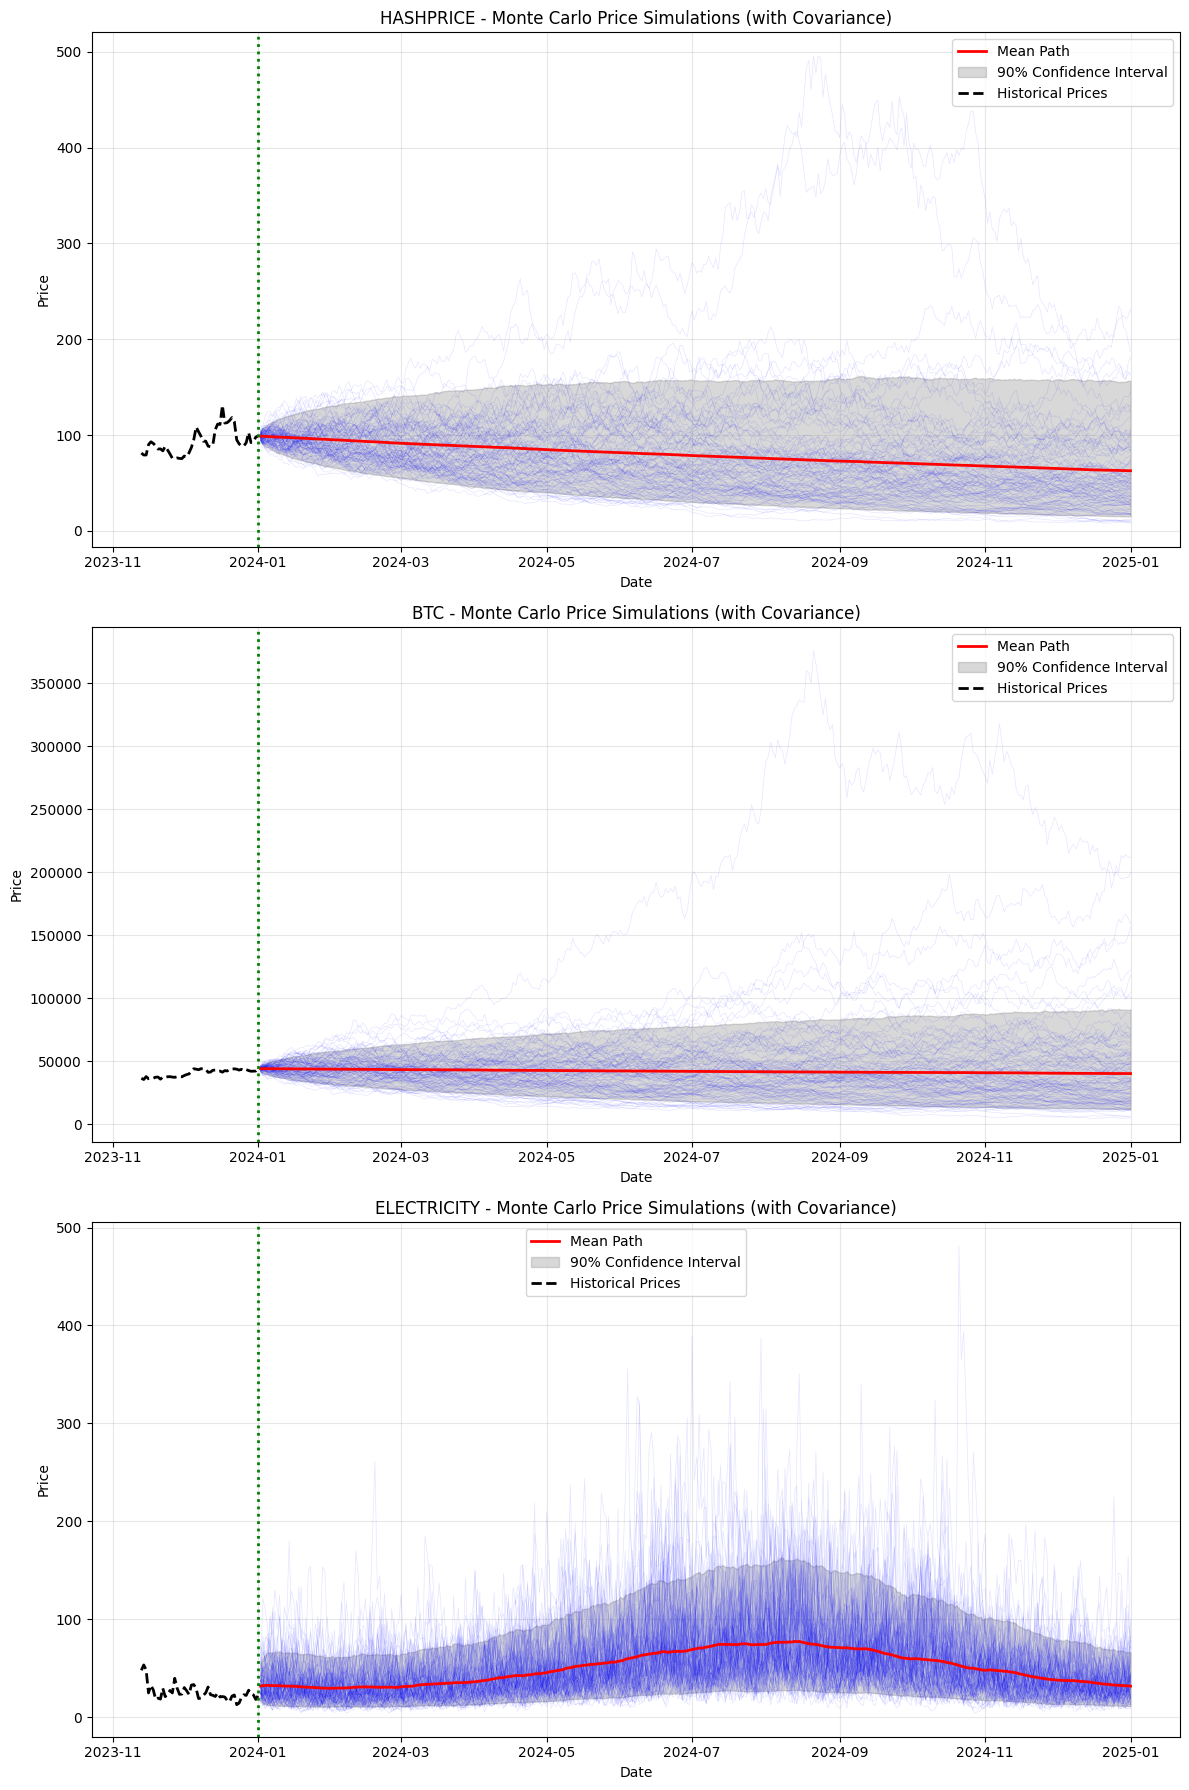

In [15]:
# Convert simulated returns back to price levels
# Since we used log returns: log(P_t) - log(P_{t-1}) = log(P_t / P_{t-1})
# To get prices: P_t = P_{t-1} * exp(return_t)

price_simulations = {}

for key in simulations.keys():
    if key == 'electricity':
        price_paths = np.exp(simulations[key])
        price_simulations[key] = price_paths
    else:
        # Get the last actual price from training data
        last_price = df_data_train[key].iloc[-1]
        
        # Get simulated returns paths
        returns_paths = simulations[key]
        
        # Convert to price paths
        # Start with last price, then apply cumulative returns
        price_paths = np.zeros_like(returns_paths)
        price_paths[:, 0] = last_price
        
        for t in range(1, returns_paths.shape[1]):
            # P_t = P_{t-1} * exp(return_t)
            price_paths[:, t] = price_paths[:, t-1] * np.exp(returns_paths[:, t])
        
        price_simulations[key] = price_paths

# Plot price simulations
fig, axes = plt.subplots(len(price_simulations), 1, figsize=(12, 6*len(price_simulations)))
if len(price_simulations) == 1:
    axes = [axes]

for idx, (key, paths) in enumerate(price_simulations.items()):
    ax = axes[idx]
    
    # Plot all simulation paths (with transparency)
    for i in range(min(100, n_simulations)):  # Plot first 100 paths for clarity
        ax.plot(future_dates, paths[i, 1:], alpha=0.1, color='blue', linewidth=0.5)
    
    # Plot mean path
    mean_path = np.mean(paths, axis=0)
    ax.plot(future_dates, mean_path[1:], color='red', linewidth=2, label='Mean Path')
    
    # Plot confidence intervals (5th and 95th percentiles)
    percentile_5 = np.percentile(paths, 5, axis=0)
    percentile_95 = np.percentile(paths, 95, axis=0)
    ax.fill_between(future_dates, percentile_5[1:], percentile_95[1:], 
                     alpha=0.3, color='gray', label='90% Confidence Interval')
    
    # Plot historical prices (last 50 days for context)
    historical_dates = df_data_train.index[-50:]
    historical_prices = df_data_train[key].values[-50:]
    ax.plot(historical_dates, historical_prices, color='black', linewidth=2, 
            label='Historical Prices', linestyle='--')
    
    ax.set_title(f'{key.upper()} - Monte Carlo Price Simulations (with Covariance)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add vertical line to separate historical and forecast
    ax.axvline(x=last_date, color='green', linestyle=':', linewidth=2, label='Forecast Start')

plt.tight_layout()
plt.show()

## Summary Statistics


In [16]:
# Calculate summary statistics for the simulations
print("Monte Carlo Simulation Summary Statistics (with Covariance)")
print("=" * 60)

# Print correlation information
if len(multivariate_params['series_names']) >= 2:
    print(f"\nModel Correlation: {multivariate_params['corr_matrix'][0,1]:.4f}")
    # Calculate correlation of final prices
    final_prices_1 = price_simulations[multivariate_params['series_names'][0]][:, -1]
    final_prices_2 = price_simulations[multivariate_params['series_names'][1]][:, -1]
    final_price_corr = np.corrcoef(final_prices_1, final_prices_2)[0, 1]
    print(f"Simulated Final Price Correlation: {final_price_corr:.4f}")

for key in price_simulations.keys():
    paths = price_simulations[key]
    final_prices = paths[:, -1]  # Prices at the end of forecast period
    initial_price = paths[0, 0]
    
    print(f"\n{key.upper()}:")
    print(f"  Initial Price: ${initial_price:,.2f}")
    print(f"  Final Price Statistics (after {n_days_forecast} days):")
    print(f"    Mean: ${np.mean(final_prices):,.2f}")
    print(f"    Median: ${np.median(final_prices):,.2f}")
    print(f"    Std Dev: ${np.std(final_prices):,.2f}")
    print(f"    5th Percentile: ${np.percentile(final_prices, 5):,.2f}")
    print(f"    95th Percentile: ${np.percentile(final_prices, 95):,.2f}")
    print(f"  Expected Return: {((np.mean(final_prices) / initial_price) - 1) * 100:.2f}%")
    print(f"  Volatility (annualized): {np.std(final_prices) / initial_price * np.sqrt(365) * 100:.2f}%")


Monte Carlo Simulation Summary Statistics (with Covariance)

Model Correlation: 0.4202
Simulated Final Price Correlation: 0.3736

HASHPRICE:
  Initial Price: $98.96
  Final Price Statistics (after 366 days):
    Mean: $62.76
    Median: $48.55
    Std Dev: $51.73
    5th Percentile: $15.22
    95th Percentile: $156.73
  Expected Return: -36.58%
  Volatility (annualized): 998.69%

BTC:
  Initial Price: $44,167.33
  Final Price Statistics (after 366 days):
    Mean: $40,251.32
    Median: $33,051.79
    Std Dev: $27,134.06
    5th Percentile: $12,156.94
    95th Percentile: $91,314.44
  Expected Return: -8.87%
  Volatility (annualized): 1173.71%

ELECTRICITY:
  Initial Price: $22.06
  Final Price Statistics (after 366 days):
    Mean: $31.51
    Median: $27.34
    Std Dev: $17.88
    5th Percentile: $11.41
    95th Percentile: $65.86
  Expected Return: 42.81%
  Volatility (annualized): 1547.80%


In [17]:
# Save simulations to a compressed .npz file
import numpy as np
file_name = 'multivariate_simulations.npz'
price_simulations['dates'] = future_dates

print(f"Saving simulations to {file_name}...")
# Ensure simulations variable exists or handle it
if 'simulations' in locals():
    np.savez_compressed(file_name, **simulations)
    print("Done.")
else:
    print("Error: 'simulations' variable not found. Please run the simulation cells first.")

Saving simulations to multivariate_simulations.npz...
Done.
